In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pickle, os
import pandas as pd

In [2]:
DATA = Path('../../data')
AUDIO_TAGGING = DATA/'freesound-audio-tagging'
AUDIO_RECORDINGS = AUDIO_TAGGING/'audio_train'
dst_path = DATA/'free-sound/train'

In [3]:
df = pd.read_csv(AUDIO_TAGGING/'train.csv')
df.head()

,fname,label,manually_verified
0,00044347.wav,Hi-hat,0
1,001ca53d.wav,Saxophone,1
2,002d256b.wav,Trumpet,0
3,0033e230.wav,Glockenspiel,1
4,00353774.wav,Cello,1


In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
with open(dst_path/'path.pkl', 'rb') as f:
    path = pickle.load(f)

In [6]:
image_size=(224,224)

In [7]:
free_sound_train = keras.preprocessing.image_dataset_from_directory(dst_path, 
                                                                    batch_size=64, 
                                                                    image_size=image_size,
                                                                    validation_split=0.2,
                                                                    seed = 42,
                                                                    subset="training")



Found 9473 files belonging to 41 classes.
Using 7579 files for training.


2022-04-27 14:41:12.321528: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:41:12.326770: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:41:12.327047: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-27 14:41:12.327727: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [8]:
free_sound_val = keras.preprocessing.image_dataset_from_directory(dst_path, 
                                                                batch_size=64, 
                                                                image_size=image_size,
                                                                validation_split=0.2,
                                                                seed = 42,
                                                                subset="validation")


Found 9473 files belonging to 41 classes.
Using 1894 files for validation.


In [9]:
free_sound_val.class_names

['Acoustic_guitar',
 'Applause',
 'Bark',
 'Bass_drum',
 'Burping_or_eructation',
 'Bus',
 'Cello',
 'Chime',
 'Clarinet',
 'Computer_keyboard',
 'Cough',
 'Cowbell',
 'Double_bass',
 'Drawer_open_or_close',
 'Electric_piano',
 'Fart',
 'Finger_snapping',
 'Fireworks',
 'Flute',
 'Glockenspiel',
 'Gong',
 'Gunshot_or_gunfire',
 'Harmonica',
 'Hi-hat',
 'Keys_jangling',
 'Knock',
 'Laughter',
 'Meow',
 'Microwave_oven',
 'Oboe',
 'Saxophone',
 'Scissors',
 'Shatter',
 'Snare_drum',
 'Squeak',
 'Tambourine',
 'Tearing',
 'Telephone',
 'Trumpet',
 'Violin_or_fiddle',
 'Writing']

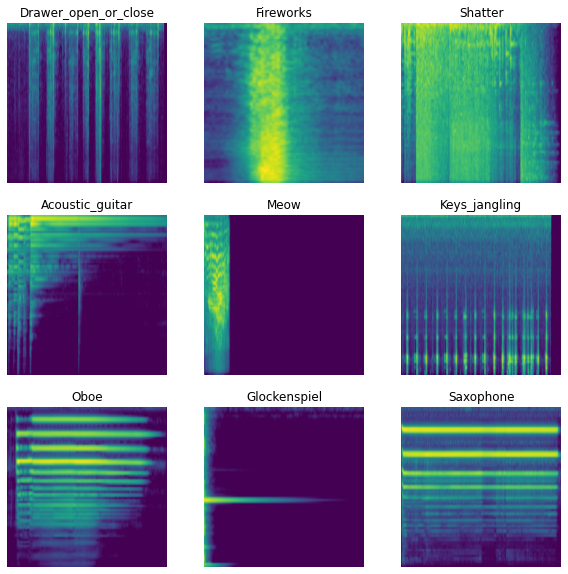

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in free_sound_train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(free_sound_train.class_names[int(labels[i])])
        plt.axis("off")

In [11]:
data_augmentation = keras.Sequential(
    [
        keras.layers.Resizing(224, 224),
        keras.layers.RandomFlip("horizontal"),
        keras.layers.RandomRotation(0.1),
        keras.layers.RandomZoom(0.1),
        keras.layers.RandomContrast(factor=0.01)
    ]
)

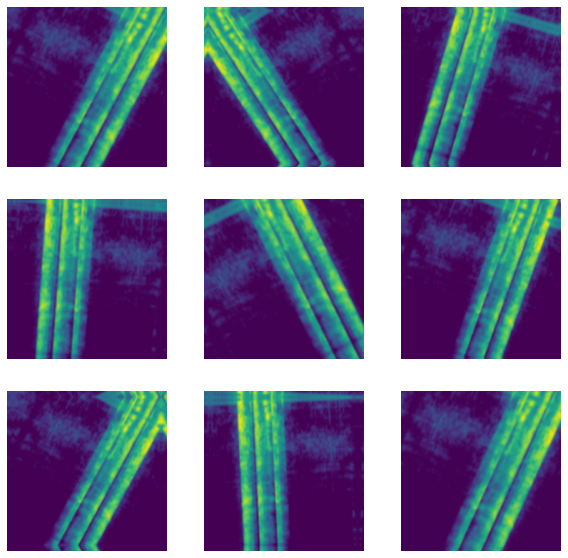

In [12]:
plt.figure(figsize=(10, 10))
for images, _ in free_sound_train.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images, training=True)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [13]:
image_size + (3,)

(224, 224, 3)

In [14]:
resnet_model = keras.applications.resnet.ResNet50(weights="imagenet",
                                                   input_shape=image_size + (3,), 
                                                   include_top=False)

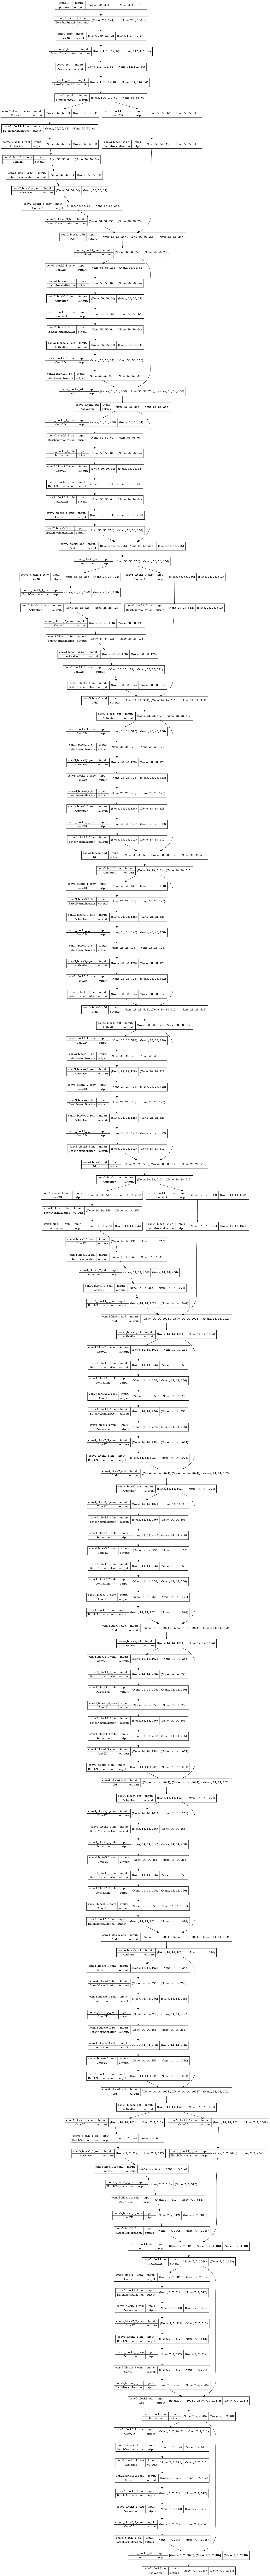

In [15]:
keras.utils.plot_model(resnet_model, show_shapes=True)

In [16]:
inputs = keras.Input(shape=image_size + (3,))
outputs = keras.applications.resnet.preprocess_input(inputs)
preprocess_m = keras.Model(inputs, outputs)

In [17]:
preprocess_m.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [19]:
batch = next(iter(free_sound_train.take(1)))[0]

In [21]:
batch.shape

TensorShape([64, 224, 224, 3])

In [22]:
np.mean(batch)

87.293526

In [23]:
batch_pred = preprocess_m.predict(batch)
batch_pred.shape

(64, 224, 224, 3)

In [24]:
batch_pred.mean()

-27.505829

In [25]:
# Inputs are images (tensors) of a particular size
inputs = keras.Input(image_size + (3,))

# Data augmentation
x = keras.layers.Resizing(224, 224)(inputs)
x = keras.layers.RandomFlip("horizontal")(x)
x = keras.layers.RandomRotation(0.1)(x)
x = keras.layers.RandomZoom(0.1)(x)
x = keras.layers.RandomContrast(factor=0.01)(x)               

# We preprocess the tensors to be compatible with the pretrained base model:
x = keras.applications.resnet.preprocess_input(x)

# Base model:
x = resnet_model(x, training=False)

# Custom head:
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(rate=0.25)(x)
x = keras.layers.Dense(512, activation="relu")(x)
x = keras.layers.BatchNormalization(axis=-1)(x)
x = keras.layers.Dropout(rate=0.5)(x)

# Outputs
outputs = keras.layers.Dense(5, activation="softmax")(x)

In [26]:
model = keras.Model(inputs, outputs)

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resizing_1 (Resizing)       (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                   

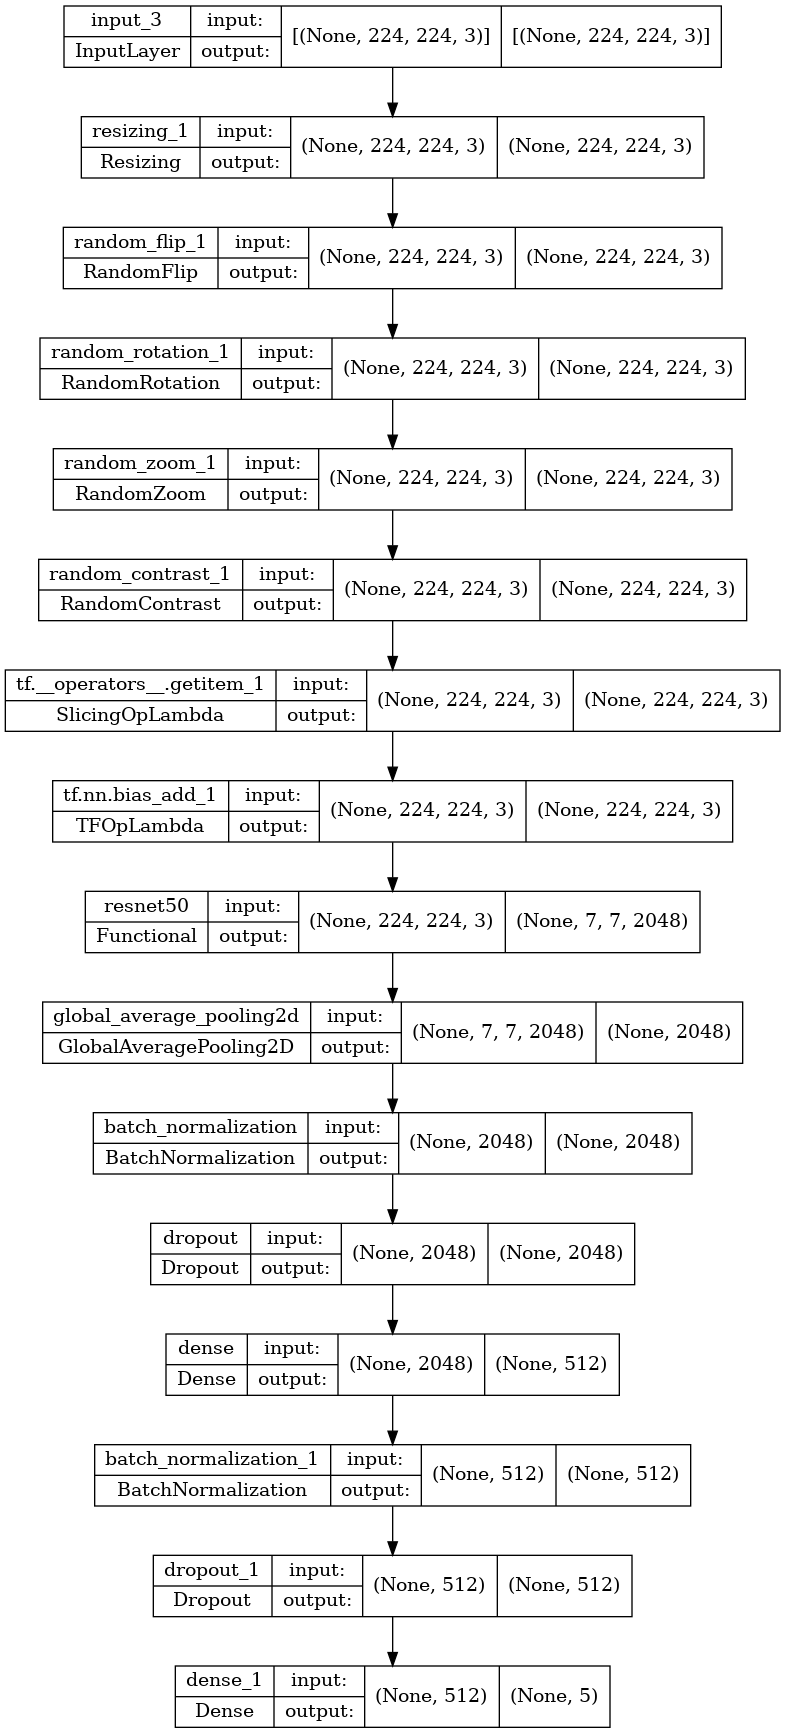

In [28]:
keras.utils.plot_model(model, show_shapes=True)

In [29]:
train_ds = free_sound_train.prefetch(buffer_size=64)
val_ds = free_sound_val.prefetch(buffer_size=64)

In [31]:
resnet_model.trainable=False

In [32]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
             metrics = "accuracy")

In [33]:
model.fit(train_ds, epochs=3, validation_data=val_ds)

Epoch 1/3


2022-04-27 14:44:22.947260: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8204


119/119 [==============================] - 28s 175ms/step - loss: nan - accuracy: 0.0318 - val_loss: nan - val_accuracy: 0.0306
Epoch 2/3
119/119 [==============================] - 19s 162ms/step - loss: nan - accuracy: 0.0319 - val_loss: nan - val_accuracy: 0.0306
Epoch 3/3
119/119 [==============================] - 19s 161ms/step - loss: nan - accuracy: 0.0319 - val_loss: nan - val_accuracy: 0.0306


In [34]:
resnet_model.trainable=True

In [35]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
             loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
             metrics = "accuracy")

In [36]:
model.fit(train_ds, epochs=2, validation_data=val_ds)

Epoch 1/2


2022-04-27 14:45:39.710847: W tensorflow/core/common_runtime/bfc_allocator.cc:462] Allocator (GPU_0_bfc) ran out of memory trying to allocate 49.00MiB (rounded to 51380224)requested by op model_1/resnet50/conv4_block6_3_bn/FusedBatchNormV3
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-04-27 14:45:39.710873: I tensorflow/core/common_runtime/bfc_allocator.cc:1010] BFCAllocator dump for GPU_0_bfc
2022-04-27 14:45:39.710881: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (256): 	Total Chunks: 256, Chunks in use: 255. 64.0KiB allocated for chunks. 63.8KiB in use in bin. 20.5KiB client-requested in use in bin.
2022-04-27 14:45:39.710886: I tensorflow/core/common_runtime/bfc_allocator.cc:1017] Bin (512): 	Total Chunks: 89, Chunks in use: 89. 44.5KiB allocated for chunks. 44.5KiB in use in bin. 44.5KiB client-requested

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/resnet50/conv4_block6_3_bn/FusedBatchNormV3' defined at (most recent call last):
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/runpy.py", line 194, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
      app.launch_new_instance()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
      app.start()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
      self.io_loop.start()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
      self._run_once()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
      handle._run()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/asyncio/events.py", line 81, in _run
      self._context.run(self._callback, *self._args)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 471, in dispatch_queue
      await self.process_one()
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 460, in process_one
      await dispatch(*args)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 367, in dispatch_shell
      await result
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/kernelbase.py", line 662, in execute_request
      reply_content = await reply_content
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 360, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/ipykernel/zmqshell.py", line 532, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 2957, in run_cell
      result = self._run_cell(
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3003, in _run_cell
      return runner(coro)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3228, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3444, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3524, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_82136/1001354588.py", line 1, in <cell line: 1>
      model.fit(train_ds, epochs=2, validation_data=val_ds)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/training.py", line 1384, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/training.py", line 1021, in train_function
      return step_function(self, iterator)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/training.py", line 1010, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/training.py", line 1000, in run_step
      outputs = model.train_step(data)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/training.py", line 859, in train_step
      y_pred = self(x, training=True)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/functional.py", line 451, in call
      return self._run_internal_graph(
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/functional.py", line 589, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/engine/base_layer.py", line 1096, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 767, in call
      outputs = self._fused_batch_norm(inputs, training=training)
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 623, in _fused_batch_norm
      output, mean, variance = control_flow_util.smart_cond(
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/utils/control_flow_util.py", line 105, in smart_cond
      return tf.__internal__.smart_cond.smart_cond(
    File "/home/oyvind/anaconda3/envs/tfx/lib/python3.8/site-packages/keras/layers/normalization/batch_normalization.py", line 605, in _fused_batch_norm_inference
      return tf.compat.v1.nn.fused_batch_norm(
Node: 'model_1/resnet50/conv4_block6_3_bn/FusedBatchNormV3'
OOM when allocating tensor with shape[64,1024,14,14] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/resnet50/conv4_block6_3_bn/FusedBatchNormV3}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_train_function_28365]

 909
2022-04-27 14:45:39.713671: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52100 of size 256 next 910
2022-04-27 14:45:39.713673: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52200 of size 256 next 911
2022-04-27 14:45:39.713676: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52300 of size 256 next 912
2022-04-27 14:45:39.713679: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52400 of size 256 next 913
2022-04-27 14:45:39.713681: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52500 of size 256 next 914
2022-04-27 14:45:39.713684: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52600 of size 256 next 915
2022-04-27 14:45:39.713687: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52700 of size 256 next 916
2022-04-27 14:45:39.713689: I tensorflow/core/common_runtime/bfc_allocator.cc:1066] InUse at 7fcc0fc52800 

2022-04-27 14:45:39.714100: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 5120 totalling 5.0KiB
2022-04-27 14:45:39.714103: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 6144 totalling 6.0KiB
2022-04-27 14:45:39.714106: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 6656 totalling 6.5KiB
2022-04-27 14:45:39.714109: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 53 Chunks of size 8192 totalling 424.0KiB
2022-04-27 14:45:39.714112: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 9216 totalling 9.0KiB
2022-04-27 14:45:39.714115: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 4 Chunks of size 10240 totalling 40.0KiB
2022-04-27 14:45:39.714119: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 11520 totalling 11.2KiB
2022-04-27 14:45:39.714122: I tensorflow/core/common_runtime/bfc_allocator.cc:1074] 1 Chunks of size 12288 totalling 12.0KiB
2022-04

In [38]:
loss, acc = model.evaluate(free_sound_val)
print("Accuracy: ", acc)

30/30 [==============================] - 4s 116ms/step - loss: nan - accuracy: 0.0306
Accuracy:  0.030623020604252815
